# HyperCC tutorial

This tutorial will show the basics of working with HyperCC!

## Prerequisites / Installation

Installation will be made easier soon! For the moment:

- Linux: HyperCC is completely untested on Windows or Mac.
- HyperCanny: Install from [GitHub:abrupt-climate/hyper-canny](http://github.com/abrupt-climate/hyper-canny)
- HyperCC: Install from [GitHub:abrupt-climate/hypercc](http://github.com/abrupt-climate/hypercc)
- Python3
- Cython
- GCC >= 7

We recommend installing HyperCanny and HyperCC into a virtual environment (see for instance: [Hitchhikers Guide to Python](http://docs.python-guide.org/en/latest/dev/virtualenvs/)). I'll assume you've run something along the lines of (your command prompt will probably look different than just `$`):

```sh
$ virtualenv -p /usr/bin/python3 climate
$ source ./climate/bin/activate
(climate) $  # "(climate)" indicates we have activated the VirtualEnv
```

Next, we need to install `numpy` to be able to compile HyperCanny.

```sh
(climate) $ pip install numpy
(climate) $ cd hyper-canny
(climate) hyper-canny$ pip install .
(climate) hyper-canny$ cd ../hypercc
(climate) hypercc$ pip install .
```

This should get you up and running! In addition, to run this notebook we need Boto3 and Pandas:

In [1]:
!pip install --quiet boto3 pandas

hypercanny-climate-module 0.1.0 requires hyper_canny, which is not installed.


## Getting data

To run this example we need to get us some climate/weather data! The UK Met Office has a public dataset on Amazon S3 called MOGREPS. I have included here a script to retrieve some of its data, It needs the `boto3` module to communicate with Amozon S3.

In [1]:
from mogreps import make_data_object_name, download_data

In [2]:
key = make_data_object_name('mogreps-g', 2016, 7, 1, 0, 0, 12)
file = download_data('mogreps-g', key)

File data/prods_op_mogreps-g_20160701_00_00_012.nc already exists.


### Exploring our data

In [3]:
import netCDF4
import pandas

The datafile contains a weather forcasts for August 1, 2016. This forecast contains many variables:

In [4]:
dataset = netCDF4.Dataset(file)

pandas.DataFrame([[
        name,
        getattr(var, 'long_name', ''),
        getattr(var, 'units', ''),
        var.shape]
        for name, var in dataset.variables.items()],
    columns=['variable', 'description', 'units', 'shape'])

,variable,description,units,shape
0,wet_bulb_freezing_level_altitude,wet_bulb_freezing_level_altitude,m,"(600, 800)"
1,latitude_longitude,,,()
2,latitude,,degrees_north,"(600,)"
3,longitude,,degrees_east,"(800,)"
4,forecast_period,,hours,()
5,forecast_reference_time,,hours since 1970-01-01 00:00:00,()
6,time,,hours since 1970-01-01 00:00:00,()
7,wet_bulb_potential_temperature,wet_bulb_potential_temperature,K,"(3, 600, 800)"
8,pressure,pressure,hPa,"(3,)"
9,air_pressure_at_sea_level,,Pa,"(600, 800)"


In [22]:
from hypercc.plotting import (plot_plate_carree)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import numpy as np

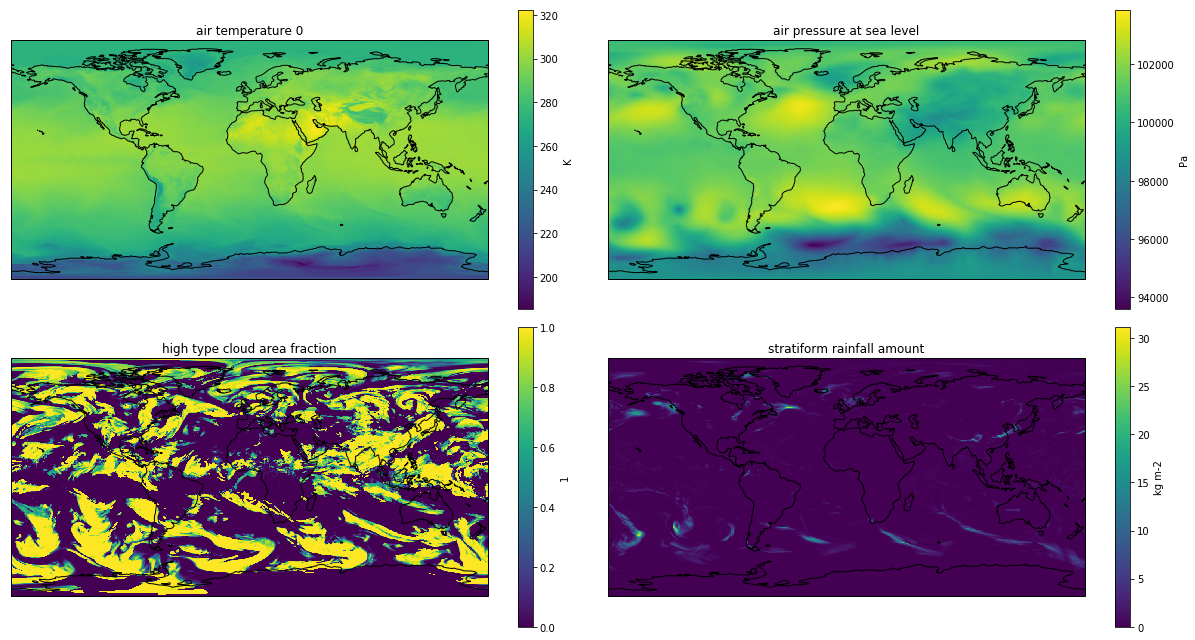

In [27]:
from itertools import product
import re

projection=ccrs.PlateCarree()
transform=ccrs.RotatedPole(pole_longitude=180.0, pole_latitude=90)

fig, ax = plt.subplots(
    2, 2, figsize=(17, 9),
    subplot_kw={'projection': projection})

lat = dataset.variables['latitude'][:]
lon = dataset.variables['longitude'][:]
variables = [['air_temperature_0', 'air_pressure_at_sea_level'],
             ['high_type_cloud_area_fraction', 'stratiform_rainfall_amount']]

for i, j in product([0, 1], [0, 1]):
    name = variables[i][j]
    plot = ax[i,j].pcolormesh(
        lon, lat,
        dataset.variables[name],
        transform=transform)
    ax[i,j].set_title(re.sub('_', ' ', name))
    ax[i,j].coastlines()
    cb = plt.colorbar(plot, ax=ax[i,j])
    cb.set_label(dataset.variables[name].units)

fig.tight_layout()
plt.show()

## Creating a `Box` instance

In [6]:
from hypercc.units import unit
from hypercc import (Box, gaussian_filter)

In [7]:
gamma = 1
scaling_factor = gamma * unit('10 km/year')
sobel_delta_t = unit('1 year')
sobel_delta_d = sobel_delta_t * scaling_factor
sobel_weights = [sobel_delta_t, sobel_delta_d, sobel_delta_d]

In [11]:
box = Box.from_netcdf(
    dataset,
    lat_var='latitude', lon_var='longitude',
    lat_bnds_var=None, lon_bnds_var=None, time_var=None)
print("{:~P}, {:~P}".format(*box.resolution))

33.35847931891444 km, 50.037712350637555 km


## Filtering with a Gaussian

In [14]:
x = dataset.variables['high_type_cloud_area_fraction'][:]

In [18]:
y = gaussian_filter(box, x, [unit('250 km'), unit('250km')])

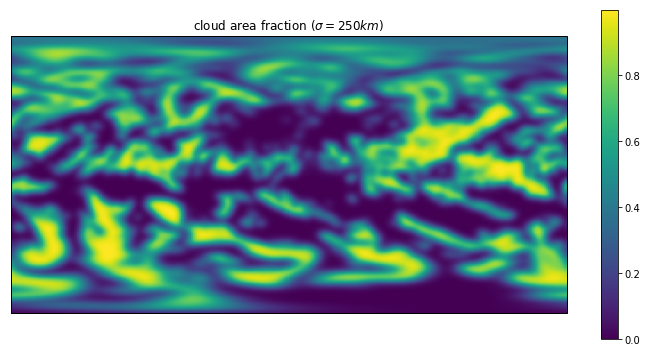

In [34]:
fig, ax = plt.subplots(
    1, 1, figsize=(10, 5),
    subplot_kw={'projection': projection})
plot = ax.pcolormesh(lon, lat, y, transform=transform)
ax.set_title('cloud area fraction ($\sigma=250 km$)')
cb = fig.colorbar(plot)
fig.tight_layout()
plt.show()

## Sobel operator

In [35]:
from hypercc import sobel_filter

In [36]:
z = sobel_filter(box, y)

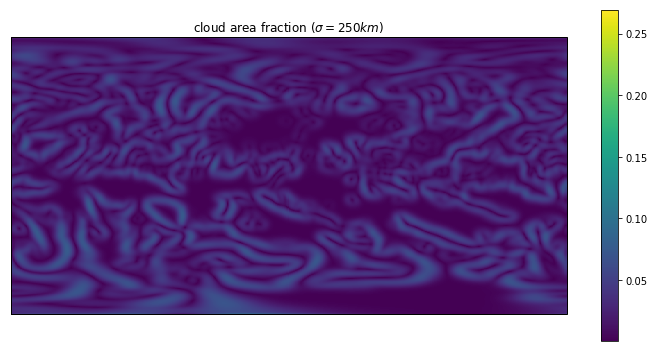

In [37]:
fig, ax = plt.subplots(
    1, 1, figsize=(10, 5),
    subplot_kw={'projection': projection})
plot = ax.pcolormesh(lon, lat, 1./z[2], transform=transform)
ax.set_title('cloud area fraction ($\sigma=250 km$)')
cb = fig.colorbar(plot)
fig.tight_layout()
plt.show()

In [38]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [44]:
m = cp_edge_thinning(z.T).T

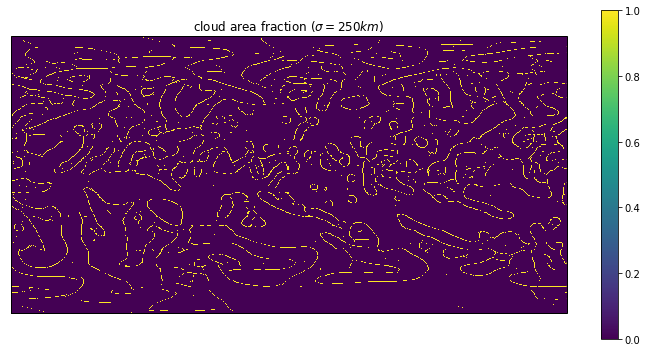

In [45]:
fig, ax = plt.subplots(
    1, 1, figsize=(10, 5),
    subplot_kw={'projection': projection})
plot = ax.pcolormesh(lon, lat, m, transform=transform)
ax.set_title('cloud area fraction ($\sigma=250 km$)')
cb = fig.colorbar(plot)
fig.tight_layout()
plt.show()

In [52]:
n = cp_double_threshold(z.T, m.T, a=1./0.03, b=1./0.01)

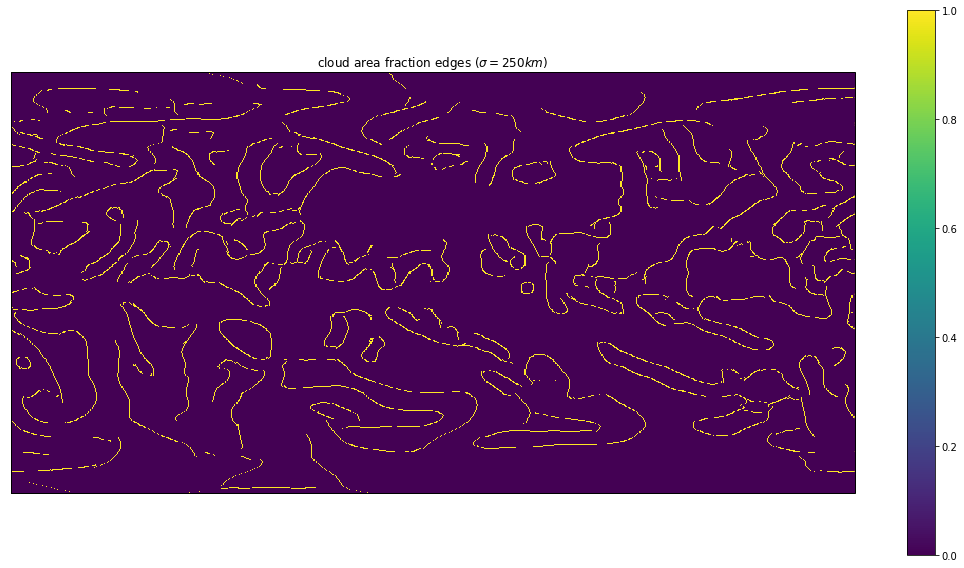

In [53]:
fig, ax = plt.subplots(
    1, 1, figsize=(15, 8),
    subplot_kw={'projection': projection})
plot = ax.pcolormesh(lon, lat, n.T, transform=transform)
ax.set_title('cloud area fraction edges ($\sigma=250 km$)')
cb = fig.colorbar(plot)
fig.tight_layout()
plt.show()